In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import os

from itertools import product

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

import cartopy
import cartopy.crs as ccrs

import xpersist as xp
cache_dir = '/glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields'
if (os.path.isdir(cache_dir)):
    xp.settings['cache_dir'] = cache_dir
os.makedirs(cache_dir, exist_ok=True)

os.environ['CESMDATAROOT'] = '/glade/scratch/mclong/inputdata'
import pop_tools


import climo_utils as cu
import utils
import discrete_obs 

import plot

In [3]:
import intake
catalog = intake.open_esm_datastore('data/campaign-cesm2-cmip6-timeseries.json')
df = catalog.search(experiment='historical', component='ocn', stream='pop.h').df
variables = df.variable.unique()

In [4]:
[v for v in variables if 'Fe' in v or 'iron' in v.lower() or 'sed' in v.lower()]

['Fe',
 'Fe_RIV_FLUX',
 'Fe_scavenge',
 'Fe_scavenge_rate',
 'Fefree',
 'IRON_FLUX',
 'Jint_100m_Fe',
 'P_iron_FLUX_100m',
 'P_iron_FLUX_IN',
 'P_iron_PROD',
 'P_iron_REMIN',
 'SedDenitrif',
 'bsiToSed',
 'calcToSed',
 'calcToSed_ALT_CO2',
 'diatFe',
 'diat_Fe_lim_Cweight_avg_100m',
 'diat_Fe_lim_surf',
 'diazFe',
 'diaz_Fe_lim_Cweight_avg_100m',
 'diaz_Fe_lim_surf',
 'dustToSed',
 'pfeToSed',
 'photoFe_diat',
 'photoFe_diaz',
 'photoFe_sp',
 'pocToSed',
 'ponToSed',
 'popToSed',
 'spFe',
 'sp_Fe_lim_Cweight_avg_100m',
 'sp_Fe_lim_surf',
 'tend_zint_100m_Fe']

In [5]:
cluster, client = utils.get_ClusterClient()
cluster.scale(12) #adapt(minimum_jobs=0, maximum_jobs=24)
client

Client Scheduler: tcp://10.12.206.33:43010 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mclong/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [12]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
ds_grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, nreg: 13, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    DXU          (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYU          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06 5.493e+06
    TAREA        (nlat, nlon) float64 1.125e+13 1.125e+13 ... 7.432e+12
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Black Sea' 'Baltic Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v7/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v7/grid/topography_20161215.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v7/grid/region_mask_20151008.ieeei4
    type:               dipole
    title:              POP_gx1v7 grid

In [80]:
nmolcm3_to_nM = 1e3
nmolcm2s_to_mmolm2yr = 1e-9 * 1e3 * 1e4 * 86400 * 365.
µmolm2d_to_mmolm2yr = 1e-3 * 365.

time_slice = slice("1990-01-15", "2015-01-15")
varlist = [
    'Fe',
    'IRON_FLUX',
    'Fe_RIV_FLUX',
    'pfeToSed',    
]
ds_list = []
for variable in varlist:
    xp_func = xp.persist_ds(cu.read_CESM_var, name=f'{variable}', trust_cache=True)    
    ds_list.append(xp_func(
        time_slice, 
        variable, 
        mean_dims=['member_id', 'time'], 
    ))
    
ds = xr.merge(ds_list)
with xr.set_options(keep_attrs=True):
    for v in ['Fe']:
        assert ds[v].attrs['units'] == 'mmol/m^3'
        ds[v] = ds[v] * nmolcm3_to_nM
        ds[v].attrs['units'] = 'nM'
    for v in ['Fe_RIV_FLUX', 'pfeToSed']:
        assert ds[v].attrs['units'] in ['nmol/cm^2/s', 'mmol/m^3 cm/s'], ds[v].attrs['units']
        ds[v] = ds[v] * nmolcm2s_to_mmolm2yr
        ds[v].attrs['units'] = 'mmol m$^{-2}$ yr$^{-1}$'        
    for v in ['IRON_FLUX']:
        assert ds[v].attrs['units'] in ['mmol/m^2/s'], ds[v].attrs['units']
        ds[v] = ds[v] * 86400. * 365. #* 1e4
        ds[v].attrs['units'] = 'mmol m$^{-2}$ yr$^{-1}$'        
            
file_fesedflux = '/glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v6/forcing/fesedfluxTot_gx1v6_cesm2_2018_c180618.nc'
file_feventflux = '/glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v6/forcing/feventflux_gx1v6_5gmol_cesm1_97_2017.nc'

dsi = xr.merge((
    xr.open_dataset(file_feventflux).rename({'FESEDFLUXIN': 'Fe_ventflux'}) * µmolm2d_to_mmolm2yr,
    xr.open_dataset(file_fesedflux).rename({'FESEDFLUXIN': 'Fe_sedflux'}) * µmolm2d_to_mmolm2yr,
)).rename({'z': 'z_t', 'y': 'nlat', 'x': 'nlon'})
dsi.Fe_ventflux.attrs['units'] = 'mmol m$^{-2}$ yr$^{-1}$'
dsi.Fe_sedflux.attrs['units'] = 'mmol m$^{-2}$ yr$^{-1}$'
ds = xr.merge((ds, dsi,))
ds['dz'] = ds_grid.dz.drop('z_t') # drop z_t because precision issues cause diffs


dsp = utils.pop_add_cyclic(ds)
for v in dsp.data_vars:
    if 'z_t' in dsp[v].dims:
        dsp[v] = dsp[v].sum('z_t')
dsp.info()


assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Fe.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/IRON_FLUX.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/Fe_RIV_FLUX.nc
assuming cache is correct
reading cached file: /glade/p/cgd/oce/projects/cesm2-marbl/xpersist_cache/3d_fields/pfeToSed.nc
xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 321 ;
	z_t = 60 ;

variables:
	float64 z_t(z_t) ;
	float64 TLAT(nlat, nlon) ;
	float64 TLONG(nlat, nlon) ;
	float32 Fe(nlat, nlon) ;
	float32 IRON_FLUX(nlat, nlon) ;
		IRON_FLUX:long_name = Atmospheric Iron Flux ;
		IRON_FLUX:units = mmol m$^{-2}$ yr$^{-1}$ ;
		IRON_FLUX:grid_loc = 2110 ;
		IRON_FLUX:cell_methods = time: mean ;
	float32 Fe_RIV_FLUX(nlat, nlon) ;
		Fe_RIV_FLUX:long_name = Dissolved Inorganic Iron Riverine Flux ;
		Fe_RIV_FLUX:units = mmol m$^{

In [ ]:
client.close()
cluster.close()
del client
del cluster

In [14]:
ds

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
Dimensions without coordinates: nlat, nlon
Data variables:
    Fe           (z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan
    IRON_FLUX    (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    Fe_RIV_FLUX  (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    pfeToSed     (nlat, nlon) float32 nan nan nan nan nan ... nan nan nan nan
    Fe_ventflux  (z_t, nlat, nlon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Fe_sedflux   (z_t, nlat, nlon) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04

In [18]:
df = discrete_obs.open_datastream('dFe')
df.obs_stream.add_model_field(ds.Fe)
df.obs_stream.add_model_field(ds_grid.REGION_MASK, method='nearest')
df

,month,lon,lat,depth,dFe_obs,Fe,REGION_MASK
0,1,210.010,-16.0018,20.0,0.540000,0.065604,2.0
1,1,210.010,-16.0018,35.0,0.440000,0.065562,2.0
2,1,210.010,-16.0019,50.0,0.480000,0.066896,2.0
3,1,210.010,-16.0019,80.0,0.400000,0.081158,2.0
4,1,210.010,-16.0020,100.0,0.390000,0.096782,2.0
...,...,...,...,...,...,...,...
27777,732519,160.051,47.0032,3929.6,0.825681,0.850402,2.0
27778,732519,160.051,47.0032,3929.8,0.902248,0.850392,2.0
27779,732519,160.051,47.0032,4900.4,0.555630,NaN,2.0
27780,732519,160.051,47.0032,4900.9,0.621851,NaN,2.0


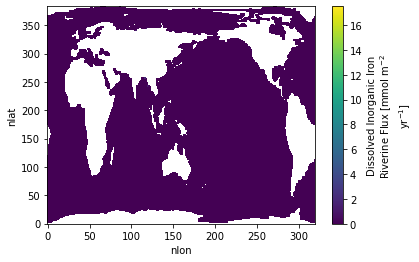

In [16]:
ds.Fe_RIV_FLUX.plot()

xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 321 ;
	z_t = 60 ;

variables:
	float64 z_t(z_t) ;
	float64 TLAT(nlat, nlon) ;
	float64 TLONG(nlat, nlon) ;
	float32 Fe(nlat, nlon) ;
	float32 IRON_FLUX(nlat, nlon) ;
		IRON_FLUX:long_name = Atmospheric Iron Flux ;
		IRON_FLUX:units = mmol m$^{-2}$ yr$^{-1}$ ;
		IRON_FLUX:grid_loc = 2110 ;
		IRON_FLUX:cell_methods = time: mean ;
	float32 Fe_RIV_FLUX(nlat, nlon) ;
		Fe_RIV_FLUX:long_name = Dissolved Inorganic Iron Riverine Flux ;
		Fe_RIV_FLUX:units = mmol m$^{-2}$ yr$^{-1}$ ;
		Fe_RIV_FLUX:grid_loc = 2110 ;
		Fe_RIV_FLUX:cell_methods = time: mean ;
	float32 pfeToSed(nlat, nlon) ;
		pfeToSed:long_name = pFe Flux to Sediments ;
		pfeToSed:units = mmol m$^{-2}$ yr$^{-1}$ ;
		pfeToSed:grid_loc = 2110 ;
		pfeToSed:cell_methods = time: mean ;
	float32 Fe_ventflux(nlat, nlon) ;
	float32 Fe_sedflux(nlat, nlon) ;
	float64 dz() ;

// global attributes:
}

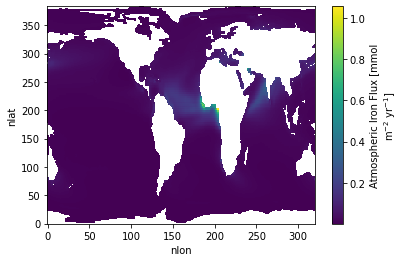

In [82]:
dsp.IRON_FLUX.plot()

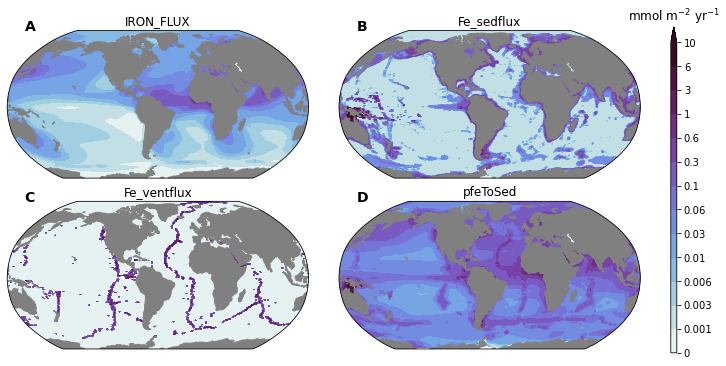

In [94]:
fields = ['IRON_FLUX', 'Fe_sedflux', 'Fe_ventflux', 'pfeToSed']

log_levels = [0., 0.001]
for scale in 10**np.arange(-3., 1., 1.):
    log_levels.extend(list(np.array([3., 6., 10.]) * scale))
    
levels = {k: log_levels for k in fields}


fig = plt.figure(figsize=(12, 6))
prj = ccrs.Robinson(central_longitude=305.0)

nrow, ncol = 2, 2 
gs = gridspec.GridSpec(
    nrows=nrow, ncols=ncol+1, 
    width_ratios=(1, 1, 0.02),
    wspace=0.15, 
    hspace=0.1,
)

axs = np.empty((nrow, ncol)).astype(object)
caxs= np.empty((nrow, ncol)).astype(object)
for i, j in product(range(nrow), range(ncol)):    
    axs[i, j] = plt.subplot(gs[i, j], projection=prj)
cax = plt.subplot(gs[:, -1])

cmap_field = cmocean.cm.dense


for n, field in enumerate(fields):
    
    i, j = np.unravel_index(n, axs.shape)
    
    ax = axs[i, j]
   
    cf = ax.contourf(
        dsp.TLONG,dsp.TLAT, dsp[field],
        levels=levels[field],
        extend='max',
        cmap=cmap_field,
        norm=colors.BoundaryNorm(levels[field], ncolors=cmap_field.N),
        transform=ccrs.PlateCarree(),
    )

    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature(
            'physical','land','110m',
            edgecolor='face',
            facecolor='gray'
        )
    )  
                             
    ax.set_title(field) #dsp[field].attrs['title_str'])
cb = plt.colorbar(cf, cax=cax, ticks=log_levels)
if 'units' in dsp[field].attrs:
    cb.ax.set_title(dsp[field].attrs['units'])
    cb.ax.set_yticklabels([f'{f:g}' for f in log_levels])
    
utils.label_plots(fig, [ax for ax in axs.ravel()], xoff=0.02, yoff=0)       
utils.savefig('iron-budget-maps.pdf')

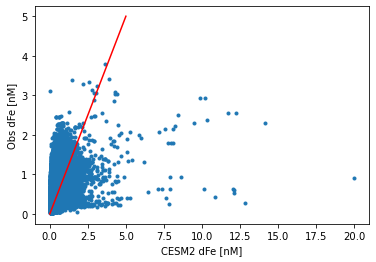

In [76]:
plt.plot(df.dFe_obs, df.Fe, '.')
plt.xlabel('CESM2 dFe [nM]')
plt.ylabel('Obs dFe [nM]')
plt.plot([0, 5], [0, 5], 'r-')

,lon,lat,depth,dfe
0,185.562505,-52.509348,579.372891,0.000365
1,185.562505,-51.975114,285.483652,0.000271
2,185.562505,-51.440880,285.483652,0.000274
3,185.562505,-50.906646,267.654199,0.000273
4,185.562505,-50.372411,209.711387,0.000271
...,...,...,...,...
146,185.562641,2.546556,5375.000000,NaN
147,185.562688,2.815616,443.377695,0.000516
148,185.562744,3.084871,1968.944219,0.000986
149,185.562812,3.354322,105.000000,0.000329


In [71]:
df = discrete_obs.obs_datastream(ds.Fe, 'dFe')
df

,month,lon,lat,depth,dFe_obs,Fe
0,1,210.010,-16.0018,20.0,0.540000,0.065604
1,1,210.010,-16.0018,35.0,0.440000,0.065562
2,1,210.010,-16.0019,50.0,0.480000,0.066896
3,1,210.010,-16.0019,80.0,0.400000,0.081158
4,1,210.010,-16.0020,100.0,0.390000,0.096782
...,...,...,...,...,...,...
27777,732519,160.051,47.0032,3929.6,0.825681,0.850402
27778,732519,160.051,47.0032,3929.8,0.902248,0.850392
27779,732519,160.051,47.0032,4900.4,0.555630,NaN
27780,732519,160.051,47.0032,4900.9,0.621851,NaN
